#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
sns.set()

#### Read in data

In [41]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
train.shape, test.shape

((2051, 81), (878, 80))

# 1. Exploratory Data Analysis

A quick overview of the data suggests 42 of our 80 independent variables will need some kind of conversion to numerical representation. But before we start encoding categoricals, the already-numeric features offer plenty of insight. Excerpts from my preliminary EDA process follow.

In [3]:
print('train.csv | shape:', train.shape, f'\n{train.dtypes.value_counts()}\n') # print train shape & dtypes

train.csv | shape: (2051, 81) 
object     42
int64      28
float64    11
dtype: int64



#### An eyebrow-raising discovery
*Has Marty McFly ever visited to Iowa?*

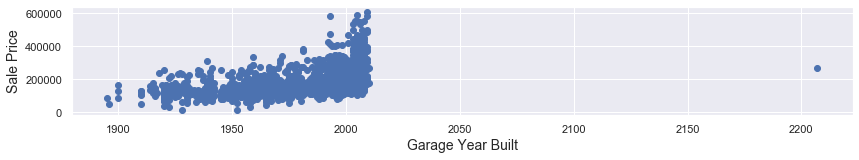

In [4]:
plt.figure(figsize=(14,2)), plt.scatter('Garage Yr Blt', 'SalePrice', data=train);
plt.xlabel('Garage Year Built', fontsize=14), plt.ylabel('Sale Price', fontsize=14);

A typo in the `Garage Yr Built` column reads **2207.** Leaving the error would not ruin our model, but it can't hurt to fix.

In [5]:
# guessing only one digit is an error, so 2207 --> 2007
train['Garage Yr Blt'].replace(2207, 2007, inplace=True);

---
### To drop outliers or to log transform?

A handful of continous independent variables contain outliers that could skew the correlation coefficient for their larger categories. We may end up dropping these outliers manually, but a simple log transformation sometimes works to normalize skewed distributions without artifically manipulating specific values. I plot both possibilities to visualize what happens to outliers under each approach.

In [6]:
X_transform = ['Wood Deck SF', 'Lot Frontage','Lot Area','Mas Vnr Area',
               'Bsmt Unf SF' , 'Garage Area', '2nd Flr SF']

#### Visualizing potential resolutions to skewed distributions in key X variables

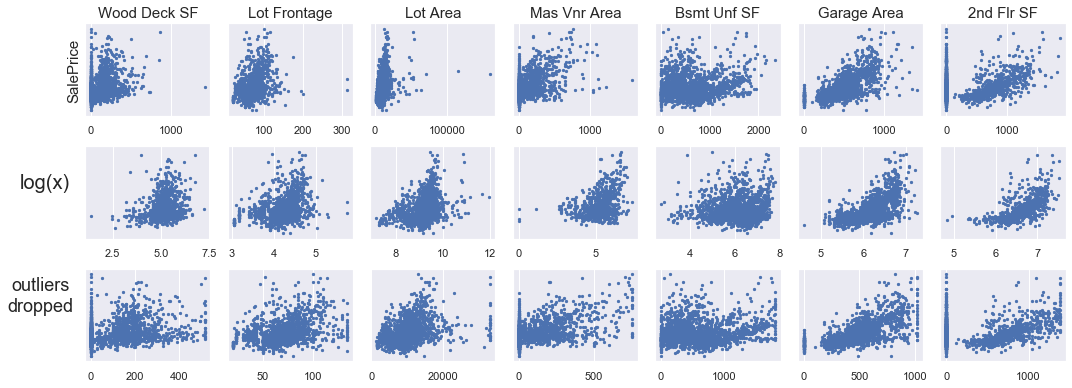

In [7]:
fig, axs = plt.subplots(3, 7, sharey=True, figsize=(15,5.5))
for i, x in enumerate(X_transform):
    axs[0, i].scatter(train[x], train['SalePrice'], s=5) ## plot X
    axs[0, i].set_title(x, fontsize=15)
    axs[1, i].scatter((train[x]).apply(np.log), train['SalePrice'], s=5) ## plot log(X)
    drop_o = train.mask((train[x] > train[x].quantile(0.99)),
                        train[x].quantile(0.99))[x]
    axs[2, i].scatter(drop_o, train['SalePrice'], s=5) ## plot X with dropped outliers

# labels & layout:
axs[2, 0].set_ylabel('outliers\ndropped', fontsize=18, rotation=0, labelpad=45)
axs[1, 0].set_ylabel('log(x)', fontsize=20, rotation=0, labelpad=40)
axs[0, 0].set_ylabel('SalePrice', fontsize=15)
plt.setp(axs,  yticks=[]), plt.tight_layout();

### Winner: dropping outliers
Bringing the houses with values in the top 1% down to the 99th percentile appears to achieve the desired effect of straightening out the graphs better than log-transforming X in nearly every case. But before making any transformations, we should cut our work in half by **combining `train` and `test`:**

---
# 2. Cleaning & Feature Engineering

In [8]:
# Combine train and test datasets into one working dataframe:

test['SalePrice'] = np.nan      # create empty SalePrice column in test
test['dataset'] = 1             # id test data with  'dataset' col = 1
train['dataset'] = 0            # id train data with 'dataset' col = 0
df = pd.concat([test, train])   # <--concatenate
df.reset_index(inplace=True)    # get 'Id' column

**Drop** (and dummify) **outliers in combined dataset:**

In my EDA I found that decreasing outlier values (rather than log transforming) key independent variables achieved the best results for normalizing the distributions of their categories. But the fact that a given value is an outlier is still important information. Before dropping values from the top 1% down to the 99th percentile in the original columns,  we'll create a dummy column to represent houses that started with outlier values in each feature.

In [9]:
# dummy & drop outliers in selected continuous variables
for x in X_transform:
    top_quant = df[x].quantile(0.99) # define 99th percentile in each column
    outliers = (df[x] > top_quant)   # define mask containing top 1% values
    df[x+'_top1p'] = outliers*1      # create dummy column for top 1% values
    df[x] = df.mask(outliers, top_quant)[x]  # replace top 1% values with 99th percentile

### Imputing `isna`
Most of the missing values (`.isna`) in our dataset essentially indicate that a house "has 0 of" or "does not have" a given feature or category. Accordingly, accross nearly every categore we can simply replace missing values with `0`.

The only exception is `Garage Yr Blt`, where instead of using `0` I replace missing cells with the corresponding house's `Year Built` .

In [10]:
for col in df.columns:
    if col == 'Garage Yr': df[col] = df[col].fillna(df['Year Built'])
    else: df[col] = df[col].fillna(0)

Now we can address features by category to learn more, clean more, and engineer more columns. 
## A) Continuous features

In [42]:
len(continuous_x)

25

In [11]:
continuous_x = ['Lot Frontage', 'Lot Area', 'Year Built', 'Year Remod/Add',
                'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
                'Mas Vnr Area', '1st Flr SF', '2nd Flr SF', 'Pool Area',
                'Low Qual Fin SF', 'Screen Porch', 'Gr Liv Area', 'Garage Yr Blt',
                'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                '3Ssn Porch', 'Misc Val', 'TotRms AbvGrd', 'Yr Sold', 'Mo Sold']

# 5 strongest continuous X by r to SalePrice:
train.corr().loc['SalePrice', continuous_x].sort_values(ascending=False)[:5]

Gr Liv Area      0.697038
Garage Area      0.650270
Total Bsmt SF    0.628925
1st Flr SF       0.618486
Year Built       0.571849
Name: SalePrice, dtype: float64

#### Define `Total_(SF)` columns

In [12]:
# sum & interact Porch SF:
df['Total Porch'] = df['Open Porch SF']+df['Enclosed Porch']+df['3Ssn Porch']+df['Screen Porch']
df['Porch_inter'] = df['Open Porch SF']*df['Enclosed Porch']*df['3Ssn Porch']*df['Screen Porch']

In [13]:
# sum & interact other SF:
df['Total SF'] = df['Gr Liv Area'] + df['Total Bsmt SF'] + df['Total Porch'] + df['Garage Area']
df['SF_inter'] = df['Gr Liv Area']*df['Total Bsmt SF']*df['Total Porch']*df['Garage Area']

#### Define `has_(feature)` columns

A number of variables show show very little correlation to Sale Price, so we don't necessarily want to include them in our model as-is. Perhaps the most important information we can learn from these categories is whether a house **has** (`= 1`) or **does not have** (`=0`) the measured feature. 

In [14]:
df['has_Pool'] = [1 if x >0 else 0 for x in df['Pool Area']]
df['has_BsFn2'] = [1 if x >0 else 0 for x in df['BsmtFin SF 2']]
df['has_BsUnf'] = [1 if x >0 else 0 for x in df['Bsmt Unf SF']]
df['has_LoQuFin'] = [1 if x > 0 else 0 for x in df['Low Qual Fin SF']]
df['has_EncPo'] = [1 if x > 0 else 0 for x in df['Enclosed Porch']]
df['has_ScrPo'] = [1 if x > 0 else 0 for x in df['Screen Porch']]
df['has_3SsPo'] = [1 if x > 0 else 0 for x in df['3Ssn Porch']]

#### Categorize `Yr Sold` and `Mo Sold`

Although they are both technically continous, converting these variables to categoricals may help isolate more granular trends like lower sale prices in Winter or the national housing crisis in 2008. Their `string`-type duplicates will get dummy columns when we call `pd.get_dummies` later on. 

In [15]:
df[['Yr Sold_cat', 'Mo Sold_cat']] = df[['Yr Sold', 'Mo Sold']].astype('str')

And finally...
#### drop the weakest remaining terms

In [16]:
df.drop(columns=['Bsmt Unf SF', 'BsmtFin SF 2', 'Low Qual Fin SF',
                 'Screen Porch', '3Ssn Porch', 'Enclosed Porch', 'Pool Area', ], inplace=True)

---
## B) Ordinal Features

Ordinal features are indicated as such in the [source data dictionary](http://jse.amstat.org/v19n3). By mapping a simple numerical scale onto ordinal categories we can visualize correlations and allow our model to identify linear trends with the target variable, SalePrice. Encoding starts at 0 for "none" or "typical" and ranks additional tiers with an integer scale of step size 1.

In [43]:
len(continuous_x)

25

In [17]:
ordinal_x = ['BsmtFin Type 1', 'BsmtFin Type 2', 'Exter Qual', 'Exter Cond', 'Bsmt Cond', 
             'Bsmt Qual', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
             'Garage Cond', 'Pool QC', 'Lot Shape', 'Utilities', 'Land Slope', 'Bsmt Exposure',
             'Electrical', 'Functional', 'Garage Finish', 'Paved Drive', 'Fence', 'Overall Qual',
             'Overall Cond', 'Mo Sold', ]

**Encoding ordinal scales**
*( ≈ applying linear scales to subjective measures ≈ data science)*

In [18]:
ordinal_x = ['BsmtFin Type 1', 'BsmtFin Type 2', 'Exter Qual', 'Exter Cond', 'Bsmt Cond', 
             'Bsmt Qual', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
             'Garage Cond', 'Pool QC', 'Lot Shape', 'Utilities', 'Land Slope', 'Bsmt Exposure',
             'Electrical', 'Functional', 'Garage Finish', 'Paved Drive', 'Fence', 'Overall Qual',
             'Overall Cond', 'Mo Sold', ]

In [19]:
# standard scale:
standard_map =  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None':0}
standard_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Cond', 'Bsmt Qual',
               'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
               'Garage Cond', 'Pool QC']
for col in standard_cols:
    df[col] = df[col].replace(standard_map).astype('float') # encode standard ordinals

In [20]:
# basement:
bsmt_map =  { 'None': 0, 'Unf': 0, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, }
bsmt_cols = ['BsmtFin Type 1', 'BsmtFin Type 2']
for col in bsmt_cols:
    df[col] = df[col].replace(bsmt_map).astype('float') # encode basement ordinals

In [21]:
# unique:
unique_ords = {
    'Lot Shape': { 'None': 0, 'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3, },
    'Utilities': { 'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, 'None': 0, },
    'Land Slope': { 'None': 0, 'Gtl': 0, 'Mod': 1, 'Sev': 2, },
    'Bsmt Exposure': { 'Gd': 5, 'Av': 3, 'Mn': 2, 'No': 0, 'None': 0, },
    'Electrical': { 'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 4, 'None': 0, },
    'Functional': { 'None': 0, 'Typ': 0, 'Min1': 2, 'Min2': 3, 'Mod': 4, 'Maj1': 6, 'Maj2': 7, 'Sev': 8, 'Sal': 10, },
    'Garage Finish': { 'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0, },
    'Paved Drive': { 'Y': 3, 'P': 2, 'N': 1, 'None': 0, },
    'Fence': { 'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0, },}
for col, cmap in unique_ords.items():
    df[col] = df[col].replace(cmap).astype('float') # encode unique ordinals

Now that we've encoded our ordinal variables, we can get correlations to SalePrice:

In [22]:
df[df['dataset']==0].corr().loc['SalePrice', ordinal_x].sort_values(ascending=False)[:5]

Overall Qual     0.800207
Exter Qual       0.712146
Kitchen Qual     0.692336
Bsmt Qual        0.612188
Garage Finish    0.557839
Name: SalePrice, dtype: float64

#### Convert some ordinals to binary

Many variables use an ordinal scale, but based on their distributions a few need to be separated or 'binarized' in order for our model to better identify their correlation to `SalePrice`. First I visualize these terms on my engineered scale, then I re-assign either a `1` or a `0` to bins of values.

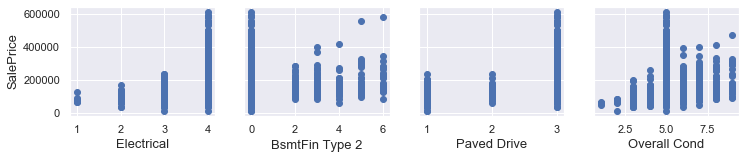

In [23]:
# visualize ordinals to convert to binary
fig, axs = plt.subplots(1, 4, figsize=(12,2))
for i, x in enumerate(['Electrical', 'BsmtFin Type 2', 'Paved Drive', 'Overall Cond']):
    axs[i].scatter(df[df['dataset']==0][x], df[df['dataset']==0]['SalePrice']);
    axs[i].set_xlabel(x, fontsize=13)
axs[0].set_ylabel('SalePrice', fontsize=13)
for ax in axs[1:]: ax.set_yticklabels([]);

In [24]:
# binarize select ordinal variables                                       # new feature function:
df['Electrical'] = [1 if x == 4 else 0 for x in df['Electrical']]         # has SBrkr
df['Paved Drive'] = [1 if x == 3 else 0 for x in df['Paved Drive']]       # has fully paved drive
df['Overall Cond'] = [1 if x >= 5 else 0 for x in df['Overall Cond']]     # overall cond >=5 
df['BsmtFin Type 2'] = [1 if x == 3 else 0 for x in df['BsmtFin Type 2']] # has BsmtFin Type 2

Similarly to above, two categories have nearly all the same values, so we will drop these columns where only outliers deviate from the mode: 

In [25]:
df.drop(columns=['Pool QC', 'Utilities',], inplace=True)

### Revert ordinals back to categorical
Some of these terms will lend themselves better than others to encoding. Assigning a numeric scale to subjective measurements is an inherently subjective process, so to be safe, I revert all my scale scales *back* to categorical — but not before making copies of the strongest encoded versions:

In [26]:
# treat as categorical and ordinal:
cat_plus_ord = ['Overall Qual', 'Exter Qual', 'Kitchen Qual', 'Heating QC', 'Bsmt Qual',
                 'Fence', 'Overall Cond', 'Garage Finish', 'Fireplace Qu', 'Garage Qual']
for x in cat_plus_ord:
    df[x+'_ord'] = df[x]        # store encoded ordinal scale
    df[x] = df[x].astype('str') # also revert to categorical for dummies

In [27]:
# treat as categorical only:
cat_only = ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Lot Shape', 'Exter Cond', 
            'Land Slope', 'Bsmt Qual', 'Overall Cond', 'Functional', 'Paved Drive', 'Bsmt Cond',
            'Garage Cond', ]
for x in cat_only:
    df[x] = df[x].astype('str') # revert to categorical for dummies

#### Log transform key ordinals
Among the ten ordinal variables where I kept the encoded numerical scale, this subset might benefit from a log transformation:

In [28]:
x_to_log =  ['Fence', 'Garage Qual', 'Garage Finish', 'Heating QC', 'Fireplace Qu', ]
for x in x_to_log:
    x+='_ord'                               # iterate on encoded (numeric) version of X
    df[x+'_log'] = (df[x]+1).apply(np.log)  # log transform X

---
## c) Nominal Features

In [44]:
len(nominal_x)

32

In [29]:
nominal_x = ['MS SubClass', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'MS Zoning',
             'Neighborhood', 'House Style', 'Condition 1', 'Condition 2','Bldg Type',
             'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
             'Mas Vnr Type', 'Foundation', 'Heating', 'Bsmt Full Bath', 'Bsmt Half Bath',
             'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Fireplaces',
             'Garage Type', 'Garage Cars', 'Sale Type', 'Lot Config',
             'Central Air',  'Misc Feature',]

#### Define `Total Bath` column

In [30]:
df['Total Bath'] = df['Bsmt Full Bath'] + df['Full Bath'] + .5*(df['Bsmt Half Bath'] + df['Half Bath'])

#### Convert a few nominals to binary (group non-mode values)

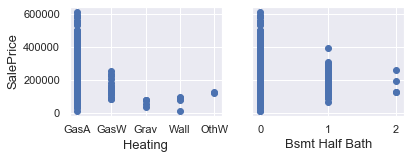

In [31]:
# visualize nominals to convert to binary
fig, axs = plt.subplots(1, 2, figsize=(6,2))
for i, x in enumerate(['Heating', 'Bsmt Half Bath']):
    axs[i].scatter(df[df['dataset']==0][x], df[df['dataset']==0]['SalePrice']);
    axs[i].set_xlabel(x, fontsize=13)
axs[0].set_ylabel('SalePrice', fontsize=13)
for ax in axs[1:]: ax.set_yticklabels([]);

In [32]:
df['Heating'] = [1 if x == 'GasA' else 0 for x in df['Heating']]            # has GasA type heating?
df['Bsmt Half Bath'] = [1 if x > 0 else 0 for x in df['Bsmt Half Bath']]    # has bsmt half bath?
df['Misc Feature'] = [1 if x == 'Shed' else 0 for x in df['Misc Feature']]  # has shed?

#### Double-check string format for categoricals
`pd.get_dummies` applies to strings, so I'll confirm that all the categories I want dummies for are string-type.

In [33]:
cat_only = ['MS SubClass', 'Street', 'Alley', 'Lot Config', 'MS Zoning', 'Neighborhood',
                'House Style', 'Condition 1',  'Condition 2', 'Bldg Type', 'House Style',
                'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                'Foundation', 'Bsmt Half Bath', 'Kitchen AbvGr', 'Heating', 'Misc Feature',
                'Garage Type', 'Sale Type', 'Land Contour', 'Central Air']
# str for dummy
df[cat_only] = df[cat_only].astype('str')

### Nominal+Numeric features
I want to treat these special categories as both nominal and numeric, so I'll create copies of the originals in string format.

In [34]:
## treat these as categorical AND numerical:
cat_plus_nom = ['Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Total Bath',
                'Bedroom AbvGr', 'Fireplaces', 'Garage Cars' ] 
# str for dummy
for x in cat_plus_nom:
    df[x+'_cat'] = df[x].astype('str')

#### Log transform key nominals
EDA showed potential for reduced loss by log transforming these nominal features:

In [35]:
for x in ['Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Total Bath', 'Fireplaces', 'Garage Cars']:
    df[x+'_log'] = (df[x]+1).apply(np.log)

---
## Final Feature Engineering
### Dummy clustered zeros
If a column has many values equal to zero (and it's not a column I've already engineered), I want to make sure my model can pick up on how having zero in that category might correlate to SalePrice. Here I create the dummy column `zero_(feature)` for each feature with >50 zero values.

In [36]:
dfx = df.drop(columns=['SalePrice', 'dataset'])
zero_cols = [col for col in dfx.columns if len(df[df[col] == 0]) > 50 and '_' not in col]
for col in zero_cols:
    df['zero_'+col] = np.where(df[col]==0, 1, 0)

### Interact 15  strongest features:

In [37]:
from sklearn.preprocessing import PolynomialFeatures

# define 15 strongest features
df_orig = df[[c for c in df.columns if '_' not in c]]
test = df_orig[df_orig['dataset']==0]
best_r = list(test.corr()['SalePrice'].abs().sort_values(ascending=False).index)[1:8]

# define df with 15 strongest columns
dfp = df[best_r]
dfp.head(2)
poly = PolynomialFeatures()
dfp_fit = poly.fit_transform(dfp) # 2nd-degree interact top 15 columns  

# concat polynomial df with combined df
df_poly = pd.DataFrame(dfp_fit, columns = poly.get_feature_names(dfp.columns))
df = pd.concat([df, df_poly], axis=1)

# `pd.get_dummies`

In [38]:
df = pd.get_dummies(df, drop_first=True)
df.shape

(2929, 410)

---
### Recover train and test

In [39]:
# define train X and y
X_train = df[df['dataset'] == 0]
y_train = pd.DataFrame(X_train['SalePrice'])
X_train.drop(columns='dataset', inplace=True)
X_train.drop(columns='SalePrice', inplace=True)

# define test X
X_test = df[df['dataset'] == 1]
X_test.drop(columns='dataset', inplace=True)
X_test.drop(columns='SalePrice', inplace=True)

/Users/jfitz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Export

In [40]:
Xy_train = pd.concat([X_train, y_train], axis=1)

Xy_train.to_csv('./datasets/Xy_train_inter8.csv', index=False)
X_test.to_csv('./datasets/X_test_inter8.csv', index=False)